# Multi-Output CNN for Side-Channel Analysis
- ASCAD Dataset with de-synchronization countermeasures
- CNN exploits translation-invariance to handle random shifts
- 256 key guesses, each with its own branch
- LSB leakage model: $L_k = \text{Sbox}[P \oplus k] \mod 2$

# 1. Imports


In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.config import (
    CNN_LEARNING_RATE, CNN_FILTERS, CNN_KERNEL_1, CNN_KERNEL_2,
    CNN_POOL_1, CNN_POOL_2, CNN_INPUT_SIZE, CNN_BATCH_SIZE,
    NUM_TRACES, TRACE_START_IDX, TARGET_BYTE_IDX, CNN_NUM_EPOCHS,
    FILE_PATH, CHECKPOINT_DIR, CNN_MODEL_FILENAME
)
from src.cnn_model import CNNMultiOutputNet, save_cnn_model
from src.utils import load_ascad, normalize_traces, generate_labels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 2. Configuration


In [11]:
print("CNN Configuration:")
print(f"  CNN_FILTERS:    {CNN_FILTERS}")
print(f"  CNN_KERNEL_1:   {CNN_KERNEL_1}")
print(f"  CNN_KERNEL_2:   {CNN_KERNEL_2}")
print(f"  CNN_POOL_1:     {CNN_POOL_1}")
print(f"  CNN_POOL_2:     {CNN_POOL_2}")
print(f"  CNN_INPUT_SIZE: {CNN_INPUT_SIZE}")
print(f"  CNN_BATCH_SIZE: {CNN_BATCH_SIZE}")
print(f"  CNN_NUM_EPOCHS: {CNN_NUM_EPOCHS}")
print(f"  NUM_TRACES:     {NUM_TRACES}")
print()
print("OneCycleLR Schedule:")
print(f"  Base LR:        {CNN_LEARNING_RATE}")
print(f"  Max LR:         {CNN_LEARNING_RATE * 10} (10× base)")
print(f"  Warmup:         30% of training")
print(f"  Final LR:       {CNN_LEARNING_RATE / 25:.2e} (base/25)")


CNN Configuration:
  CNN_FILTERS:    4
  CNN_KERNEL_1:   32
  CNN_KERNEL_2:   16
  CNN_POOL_1:     2
  CNN_POOL_2:     4
  CNN_INPUT_SIZE: 480
  CNN_BATCH_SIZE: 1000
  CNN_NUM_EPOCHS: 50
  NUM_TRACES:     10000

OneCycleLR Schedule:
  Base LR:        0.0001
  Max LR:         0.001 (10× base)
  Warmup:         30% of training
  Final LR:       4.00e-06 (base/25)


## 3. Dataset Loading


In [12]:
traces, plaintexts, real_key = load_ascad(
    FILE_PATH, 
    num_traces=NUM_TRACES, 
    start_idx=TRACE_START_IDX, 
    target_byte=TARGET_BYTE_IDX
)

# Slice to CNN input size and normalize
traces = traces[:, :CNN_INPUT_SIZE]
traces_tensor = normalize_traces(traces)
print("Traces shape:", traces_tensor.shape)
print("Real Key Byte:", hex(real_key))


Traces shape: torch.Size([10000, 480])
Real Key Byte: 0xe0


## 4. Label Generation


In [13]:
labels_tensor = generate_labels(plaintexts)
print("Labels shape:", labels_tensor.shape)


Labels shape: torch.Size([10000, 256])


## 5. CNN Model Architecture

- Shared: Conv(4x32) → BN → AvgPool(2) → ReLU → Conv(4x16) → BN → AvgPool(4) → ReLU
- 256 Branches: Flatten → Dense(2) with Softmax


In [14]:
model = CNNMultiOutputNet(
    input_size=CNN_INPUT_SIZE,
    filters=CNN_FILTERS,
    kernel1=CNN_KERNEL_1,
    kernel2=CNN_KERNEL_2,
    pool1=CNN_POOL_1,
    pool2=CNN_POOL_2
).to(device)

print(f"CNN model created with input_size={CNN_INPUT_SIZE}, flat_size={model.flat_size}")


CNN model created with input_size=480, flat_size=208


## 6. Training Loop

- Loss: $\mathcal{L}_{total} = \frac{1}{256}\sum_{k=1}^{256} \mathcal{L}^{[k]}$ (cross-entropy per branch)
- Optimizer: Adam with **OneCycleLR** scheduler
- LR Schedule: Warmup → Peak (10× base) → Cosine annealing → Final (base/25)


In [ ]:
dataset = TensorDataset(traces_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=CNN_BATCH_SIZE, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CNN_LEARNING_RATE)

# OneCycleLR: warmup → peak → cosine decay
# max_lr = 10x base, div_factor=10 (start at base), final_div_factor=25 (end at base/25)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=CNN_LEARNING_RATE * 10,
    epochs=CNN_NUM_EPOCHS,
    steps_per_epoch=len(loader),
    pct_start=0.3,           # 30% warmup
    anneal_strategy='cos',   # cosine annealing
    div_factor=10,           # initial_lr = max_lr / 10
    final_div_factor=25      # final_lr = initial_lr / 25
)

key_scores = np.zeros((CNN_NUM_EPOCHS, 256))
lr_history = []

for epoch in range(CNN_NUM_EPOCHS):
    model.train()
    total_loss = 0
    epoch_lrs = []
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{CNN_NUM_EPOCHS}')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = sum(criterion(output[:, k, :], target[:, k]) for k in range(256)) / 256
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update LR after each batch
        
        total_loss += loss.item()
        epoch_lrs.append(scheduler.get_last_lr()[0])
        
    avg_lr = np.mean(epoch_lrs)
    lr_history.extend(epoch_lrs)
    print(f"Epoch {epoch+1} Avg Loss: {total_loss / len(loader):.6f} | LR: {avg_lr:.2e}")
    
    # Validation: compute loss per branch
    model.eval()
    with torch.no_grad():
        val_accum_loss = torch.zeros(256, device=device)
        val_count = 0
        
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            out = model(data)
            
            for k in range(256):
                val_accum_loss[k] += nn.CrossEntropyLoss(reduction='sum')(out[:, k, :], target[:, k])
            val_count += data.size(0)
            
        avg_branch_losses = val_accum_loss / val_count
        key_scores[epoch] = -avg_branch_losses.cpu().numpy()
        
        sorted_keys = np.argsort(key_scores[epoch])[::-1]
        best_key = sorted_keys[0]
        rank_of_real = np.where(sorted_keys == real_key)[0][0]
        
        print(f"Best Key: {hex(best_key)}, Real Key Rank: {rank_of_real}")


Epoch 1/50: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]


Epoch 1 Avg Loss: 0.798041 | LR: 1.04e-04
Best Key: 0xf8, Real Key Rank: 187


Epoch 2/50:  40%|████      | 4/10 [00:00<00:00, 10.72it/s]

## 7. Results Analysis


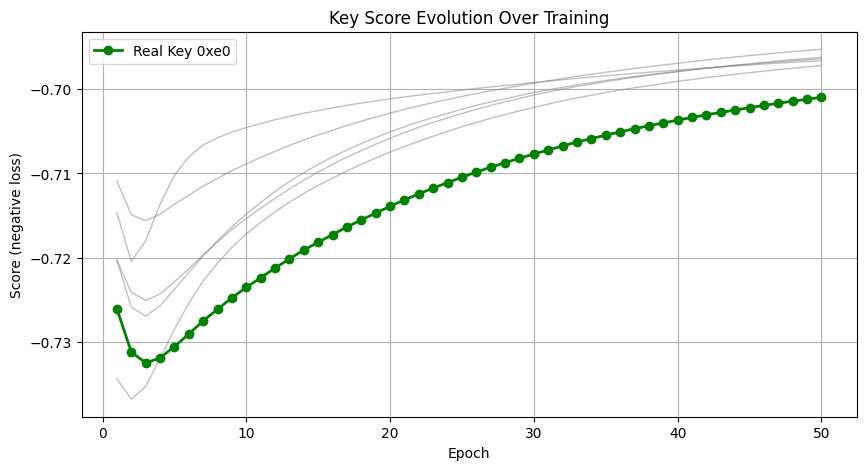

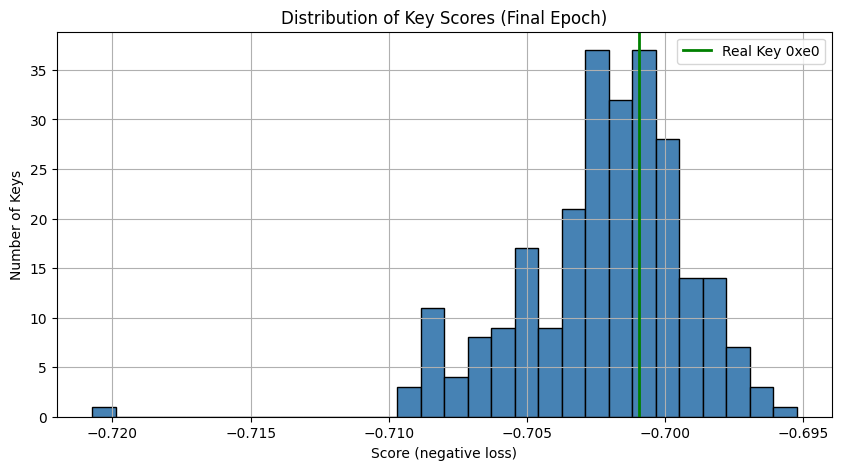

In [ ]:
final_scores = key_scores[-1]
epochs_range = np.arange(1, CNN_NUM_EPOCHS + 1)

real_key_ranks = []
for epoch in range(CNN_NUM_EPOCHS):
    sorted_keys = np.argsort(key_scores[epoch])[::-1]
    rank = np.where(sorted_keys == real_key)[0][0] + 1
    real_key_ranks.append(rank)

# Chart 1: Learning Rate Schedule
fig, ax = plt.subplots(figsize=(10, 4))
steps = np.arange(1, len(lr_history) + 1)
ax.plot(steps, lr_history, color='#e63946', linewidth=2)
ax.fill_between(steps, lr_history, alpha=0.3, color='#e63946')
ax.set_xlabel('Training Step')
ax.set_ylabel('Learning Rate')
ax.set_title('OneCycleLR Schedule: Warmup → Peak → Cosine Decay')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Mark phases
warmup_end = int(len(lr_history) * 0.3)
ax.axvline(x=warmup_end, color='#457b9d', linestyle='--', alpha=0.7, label='Warmup End (30%)')
ax.legend()
plt.tight_layout()
plt.show()

# Chart 2: Key Score Evolution
plt.figure(figsize=(10, 5))
sorted_final = np.argsort(final_scores)[::-1]
for k in sorted_final[:5]:
    if k != real_key:
        plt.plot(epochs_range, key_scores[:, k], color='gray', alpha=0.5, linewidth=1)
plt.plot(epochs_range, key_scores[:, real_key], color='green', linewidth=2, 
         marker='o', label=f'Real Key {hex(real_key)}')
plt.xlabel('Epoch')
plt.ylabel('Score (negative loss)')
plt.title('Key Score Evolution Over Training')
plt.legend()
plt.grid(True)
plt.show()

# Chart 3: Score Distribution
plt.figure(figsize=(10, 5))
plt.hist(final_scores, bins=30, color='steelblue', edgecolor='black')
plt.axvline(x=final_scores[real_key], color='green', linewidth=2, label=f'Real Key {hex(real_key)}')
plt.xlabel('Score (negative loss)')
plt.ylabel('Number of Keys')
plt.title('Distribution of Key Scores (Final Epoch)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("=" * 50)
print("ATTACK SUMMARY")
print("=" * 50)
print(f"Target Key Byte:  {hex(real_key)}")
print(f"Final Rank:       {real_key_ranks[-1]}")
print(f"Final Score:      {final_scores[real_key]:.4f}")
if real_key_ranks[-1] == 1:
    print("Result:           KEY RECOVERED!")
else:
    print(f"Result:           Key not recovered (rank {real_key_ranks[-1]})")
print("=" * 50)


ATTACK SUMMARY
Target Key Byte:  0xe0
Final Rank:       93
Final Score:      -0.7010
Result:           Key not recovered (rank 93)


## 8. Save Model


In [ ]:
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
model_path = os.path.join(CHECKPOINT_DIR, CNN_MODEL_FILENAME)

config_dict = {
    'CNN_LEARNING_RATE': CNN_LEARNING_RATE,
    'CNN_FILTERS': CNN_FILTERS,
    'CNN_KERNEL_1': CNN_KERNEL_1,
    'CNN_KERNEL_2': CNN_KERNEL_2,
    'CNN_POOL_1': CNN_POOL_1,
    'CNN_POOL_2': CNN_POOL_2,
    'CNN_INPUT_SIZE': CNN_INPUT_SIZE,
    'CNN_BATCH_SIZE': CNN_BATCH_SIZE,
    'NUM_TRACES': NUM_TRACES,
    'CNN_NUM_EPOCHS': CNN_NUM_EPOCHS,
    'TARGET_BYTE_IDX': TARGET_BYTE_IDX,
    # OneCycleLR scheduler params
    'LR_MAX': CNN_LEARNING_RATE * 10,
    'LR_PCT_START': 0.3,
    'LR_DIV_FACTOR': 10,
    'LR_FINAL_DIV_FACTOR': 25,
}

metadata = {
    'real_key': int(real_key),
    'final_rank': real_key_ranks[-1],
    'final_score': float(final_scores[real_key]),
    'key_recovered': real_key_ranks[-1] == 1,
}

save_cnn_model(model, model_path, config=config_dict, metadata=metadata)

print(f"\nModel checkpoint saved with:")
print(f"  - Config: {len(config_dict)} parameters")
print(f"  - Metadata: Final rank={metadata['final_rank']}, Key recovered={metadata['key_recovered']}")


CNN model saved to checkpoints/cnn_multi_output_sca.pt

Model checkpoint saved with:
  - Config: 11 parameters
  - Metadata: Final rank=93, Key recovered=False
